In [75]:
from math import lgamma, exp, fabs, sqrt, copysign, isfinite
from typing import Union
import numpy as np


_PFAFF_KUMMER_THRESHOLD = (3.0 - sqrt(5.0)) / 2.0  # ~0.381966
# _PFAFF_KUMMER_THRESHOLD = 0.3
_EPS = 1e-14


def _scalar_hyper2f1(a_int: int, b: float, c: float, z: float) -> float:
    if a_int > 0:
        raise ValueError("'a_int' must be a non-positive integer")
    if a_int == 0:
        return 1.0
    if not (0.0 <= z <= 1.0):
        raise ValueError("z must be in [0,1]")
    if b <= 0 or c <= 0 or c <= b:
        raise ValueError("Require b>0, c>0, c>b")

    if fabs(z) < _EPS:
        return 1.0

    m = float(-a_int)  # m >= 1
    if fabs(z - 1.0) < _EPS:
        # Closed form at z=1 via gamma functions (ratio form) 2F1(-m,b;c;1)
        log_gamma_c = lgamma(c)
        log_gamma_c_minus_b_plus_m = lgamma(c - b + m)
        log_gamma_c_plus_m = lgamma(c + m)
        log_gamma_c_minus_b = lgamma(c - b)
        return exp(
            log_gamma_c
            + log_gamma_c_minus_b_plus_m
            - log_gamma_c_plus_m
            - log_gamma_c_minus_b
        )

    a_d = float(a_int)
    sum_val = 1.0
    term = 1.0

    if z < _PFAFF_KUMMER_THRESHOLD:
        c_minus_b = c - b
        z_pfaff = z / (z - 1.0)
        for k in range(int(m)):
            k_val = float(k)
            term *= (a_d + k_val) * (c_minus_b + k_val) * z_pfaff
            denom = (c + k_val) * (k_val + 1.0)
            term /= denom
            sum_val += term
        return (1.0 - z) ** m * sum_val
    else:
        C_prime = a_d + b - c + 1.0
        z_kummer = 1.0 - z
        for k in range(int(m)):
            k_val = float(k)
            num_factor = (a_d + k_val) * (b + k_val) * z_kummer
            den_factor = (C_prime + k_val) * (k_val + 1.0)
            if fabs(den_factor) < _EPS * _EPS:
                if fabs(num_factor) < _EPS * _EPS:
                    term = 0.0
                else:
                    term = copysign(float("inf"), num_factor / den_factor)
            else:
                term *= num_factor / den_factor
            sum_val += term
            if (not isfinite(term)) and term != 0.0:
                break

        log_gamma_c_minus_b_plus_m = lgamma(c - b + m)
        log_gamma_c = lgamma(c)
        log_gamma_c_minus_b = lgamma(c - b)
        log_gamma_c_plus_m = lgamma(c + m)
        prefactor = exp(
            log_gamma_c_minus_b_plus_m
            + log_gamma_c
            - log_gamma_c_minus_b
            - log_gamma_c_plus_m
        )
        return prefactor * sum_val


def hypergeometric_2F1_stable_v1(
    a_int: int, b: float, c: float, z: Union[float, int, np.ndarray]
):
    """Compute 2F1(a,b;c;z) for a negative integer a (terminating series).

    Supports scalar z or numpy array z; in the array case returns an array
    of matching shape.
    """
    # Restrict scalars to int/float; other dtypes (str/complex) raise early
    if isinstance(z, (int, float)):
        return _scalar_hyper2f1(a_int, b, c, float(z))
    z_arr = np.asarray(z, dtype=float)
    out = np.empty_like(z_arr)
    it = np.nditer(z_arr, flags=["multi_index"])
    while not it.finished:
        out[it.multi_index] = _scalar_hyper2f1(a_int, b, c, float(it[0]))
        it.iternext()
    return out


# print(hypergeometric_2F1_stable(-2048, 1.0, 1.5, 0.30403469))


In [81]:
from math import log, log1p
from typing import Union
import numpy as np


def _scalar_hyper2f1_negint_binomial(z:float, a_int: int, b: float, c: float):
    if a_int > 0:
        raise ValueError("'a_int' must be a non-positive integer")
    if a_int == 0:
        return 1.0
    if not (0.0 <= z <= 1.0):
        raise ValueError("z must be in [0,1]")
    if b <= 0 or c <= 0 or c <= b:
        raise ValueError("Require b>0, c>0, c>b")

    m = -int(a_int)

    # Quick edges
    if z == 0.0:
        return 1.0
    if abs(1.0-z) < 1e-12:
        log_gamma_c = lgamma(c)
        log_gamma_c_minus_b_plus_m = lgamma(c - b + m)
        log_gamma_c_plus_m = lgamma(c + m)
        log_gamma_c_minus_b = lgamma(c - b)
        return exp(
            log_gamma_c
            + log_gamma_c_minus_b_plus_m
            - log_gamma_c_plus_m
            - log_gamma_c_minus_b
        ) 

    p, q = z, 1.0 - z
    cb = c - b

    # Start at the mode to avoid underflow of (1-z)^m
    k0 = int((m + 1) * p)
    k0 = min(max(k0, 0), m)

    # Binomial weight w_{k0} via logs: C(m,k0) p^{k0} q^{m-k0}
    logw = (lgamma(m + 1) - lgamma(k0 + 1) - lgamma(m - k0 + 1)
            + k0 * log(p) + (m - k0) * log1p(-p))
    w0 = exp(logw)

    # Ratio r_{k0} = (c-b)_{k0} / (c)_{k0} via recurrence (stable, ~O(1/k))
    r0 = 1.0
    for j in range(k0):
        r0 *= (cb + j) / (c + j)

    S = r0 * w0

    # Upwards: k = k0+1..m
    w, r = w0, r0
    for k in range(k0, m):
        # w_{k+1} = w_k * ((m-k)/(k+1)) * (p/q)
        w *= ((m - k) / (k + 1.0)) * (p / q)
        # r_{k+1} = r_k * (cb + k)/(c + k)
        r *= (cb + k) / (c + k)
        S += r * w

    # Downwards: k = k0-1..0
    w, r = w0, r0
    for k in range(k0, 0, -1):
        # w_{k-1} = w_k * (k/(m-k+1)) * (q/p)
        w *= (k / (m - k + 1.0)) * (q / p)
        j = k - 1
        # r_{k-1} = r_k * (c + j)/(cb + j)
        r *= (c + j) / (cb + j)
        S += r * w

    return S

def hypergeometric_2F1_stable(
    a_int: int, b: float, c: float, z: Union[float, int, np.ndarray]
):
    """Compute 2F1(a,b;c;z) for a negative integer a using a stable binomial-sum."""
    if isinstance(z, (int, float)):
        return _scalar_hyper2f1_negint_binomial(float(z),a_int, b, c)
    z_arr = np.asarray(z, dtype=float)
    out = np.empty_like(z_arr)
    it = np.nditer(z_arr, flags=["multi_index"])
    while not it.finished:
        out[it.multi_index] = _scalar_hyper2f1_negint_binomial(float(it[0]), a_int, b, c)
        it.iternext()
    return out


In [82]:
zz = _scalar_hyper2f1_negint_binomial(0.8, -1024,1,2.3)
zz

0.0015847859123649564

In [83]:
%%timeit 
zz = _scalar_hyper2f1_negint_binomial(0.8, -1024,1,2.3)

149 μs ± 1.06 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [77]:
from scipy.special import hyp2f1

In [106]:
x = np.linspace(0,1,1024)
x = np.repeat(x[:,None], 16, axis=-1)
b = np.ones_like(x) * 1.0 + np.random.normal(0,0.01, x.shape)
c = np.ones_like(x) * 2.3

In [107]:
# %%timeit
a = hyp2f1(-1024, b, c, x)

In [108]:
a

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.67245967, 0.67415074, 0.67186419, ..., 0.67062947, 0.67215547,
        0.67497116],
       [0.47686458, 0.48023696, 0.48752699, ..., 0.48358304, 0.4805189 ,
        0.47561499],
       ...,
       [0.00125783, 0.00138858, 0.00128891, ..., 0.00110072, 0.00136731,
        0.0012968 ],
       [0.00106867, 0.00116891, 0.00123831, ..., 0.00122963, 0.00130194,
        0.00112178],
       [0.00123687, 0.00131981, 0.00133463, ..., 0.00131324, 0.00125665,
        0.00126445]], shape=(1024, 16))

In [73]:
def apply_2f1(x, a, b, c):
    return np.array([_scalar_hyper2f1_negint_binomial(xx,a,b,c) for xx in x])

In [74]:
K = 257
# @pytest.mark.parametrize("m,b,c", [(20, 2.5, 5.0), (50, 1.75, 4.2)])
apply_2f1(np.linspace(0,1,K), -20, 1.0, 5)

0.00390625
0.0078125
0.01171875
0.015625
0.01953125
0.0234375
0.02734375
0.03125
0.03515625
0.0390625
0.04296875
0.046875
0.05078125
0.0546875
0.05859375
0.0625
0.06640625
0.0703125
0.07421875
0.078125
0.08203125
0.0859375
0.08984375
0.09375
0.09765625
0.1015625
0.10546875
0.109375
0.11328125
0.1171875
0.12109375
0.125
0.12890625
0.1328125
0.13671875
0.140625
0.14453125
0.1484375
0.15234375
0.15625
0.16015625
0.1640625
0.16796875
0.171875
0.17578125
0.1796875
0.18359375
0.1875
0.19140625
0.1953125
0.19921875
0.203125
0.20703125
0.2109375
0.21484375
0.21875
0.22265625
0.2265625
0.23046875
0.234375
0.23828125
0.2421875
0.24609375
0.25
0.25390625
0.2578125
0.26171875
0.265625
0.26953125
0.2734375
0.27734375
0.28125
0.28515625
0.2890625
0.29296875
0.296875
0.30078125
0.3046875
0.30859375
0.3125
0.31640625
0.3203125
0.32421875
0.328125
0.33203125
0.3359375
0.33984375
0.34375
0.34765625
0.3515625
0.35546875
0.359375
0.36328125
0.3671875
0.37109375
0.375
0.37890625
0.3828125
0.38671875
0.3906

array([1.        , 0.98456635, 0.96950784, 0.95481336, 0.94047221,
       0.92647401, 0.91280871, 0.8994666 , 0.8864383 , 0.87371469,
       0.86128698, 0.84914664, 0.83728544, 0.82569539, 0.81436877,
       0.80329809, 0.79247612, 0.78189584, 0.77155047, 0.76143344,
       0.75153837, 0.74185911, 0.73238968, 0.72312431, 0.71405738,
       0.70518348, 0.69649735, 0.68799388, 0.67966816, 0.67151538,
       0.66353093, 0.6557103 , 0.64804915, 0.64054324, 0.6331885 ,
       0.62598094, 0.61891674, 0.61199215, 0.60520356, 0.59854746,
       0.59202044, 0.58561922, 0.57934059, 0.57318143, 0.56713874,
       0.56120959, 0.55539115, 0.54968066, 0.54407544, 0.5385729 ,
       0.53317052, 0.52786586, 0.52265653, 0.51754023, 0.51251473,
       0.50757784, 0.50272745, 0.49796151, 0.49327803, 0.48867505,
       0.48415071, 0.47970316, 0.47533064, 0.4710314 , 0.46680377,
       0.46264611, 0.45855684, 0.4545344 , 0.4505773 , 0.44668407,
       0.44285328, 0.43908356, 0.43537355, 0.43172195, 0.42812

In [63]:
np.linspace(0,1,K)

array([0.        , 0.00390625, 0.0078125 , 0.01171875, 0.015625  ,
       0.01953125, 0.0234375 , 0.02734375, 0.03125   , 0.03515625,
       0.0390625 , 0.04296875, 0.046875  , 0.05078125, 0.0546875 ,
       0.05859375, 0.0625    , 0.06640625, 0.0703125 , 0.07421875,
       0.078125  , 0.08203125, 0.0859375 , 0.08984375, 0.09375   ,
       0.09765625, 0.1015625 , 0.10546875, 0.109375  , 0.11328125,
       0.1171875 , 0.12109375, 0.125     , 0.12890625, 0.1328125 ,
       0.13671875, 0.140625  , 0.14453125, 0.1484375 , 0.15234375,
       0.15625   , 0.16015625, 0.1640625 , 0.16796875, 0.171875  ,
       0.17578125, 0.1796875 , 0.18359375, 0.1875    , 0.19140625,
       0.1953125 , 0.19921875, 0.203125  , 0.20703125, 0.2109375 ,
       0.21484375, 0.21875   , 0.22265625, 0.2265625 , 0.23046875,
       0.234375  , 0.23828125, 0.2421875 , 0.24609375, 0.25      ,
       0.25390625, 0.2578125 , 0.26171875, 0.265625  , 0.26953125,
       0.2734375 , 0.27734375, 0.28125   , 0.28515625, 0.28906

In [11]:
import matplotlib.pyplot as plt

In [15]:
a = -1024
b = 1.0
Z = []
for c in np.linspace(b+0.01, b+1.0, 20):
    Z.append(apply_2f1(a,b,c, x))


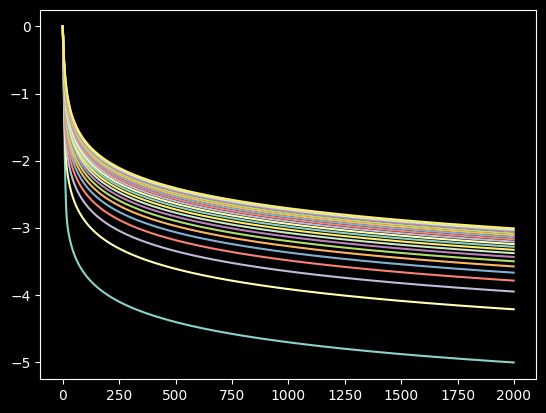

In [16]:
plt.plot(np.log10(np.array(Z).T))

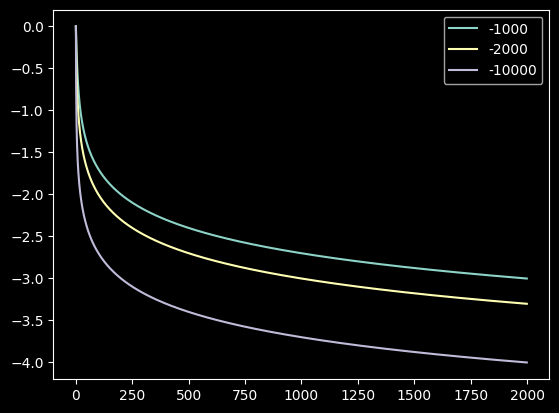

In [20]:
for k in [-1000, -2000, -10_000]:
    plt.plot(np.log10(apply_2f1(k,b,c, x)), label=str(k))
plt.legend()
plt.show()

In [21]:
x1 = np.log10(apply_2f1(-1000,b,c, x))
x2 = np.log10(apply_2f1(-10_000,b,c, x))

In [22]:
x1/x2

/tmp/ipykernel_27872/1326173185.py:1: RuntimeWarning: invalid value encountered in divide
  x1/x2


array([       nan, 0.14829335, 0.19929031, ..., 0.75007321, 0.7500868 ,
       0.75010038], shape=(2000,))

In [23]:
x1 = np.log10(apply_2f1(-1000,b,c, x))
x2 = np.log10(apply_2f1(-20_000,b,c, x))
x1/x2

/tmp/ipykernel_27872/2835266641.py:3: RuntimeWarning: invalid value encountered in divide
  x1/x2


array([       nan, 0.1040979 , 0.15319365, ..., 0.69757418, 0.69758946,
       0.69760474], shape=(2000,))

In [63]:
Z[0]

array([1.00000000e+00, 5.99353802e-01, 3.59337609e-01, 2.15544283e-01,
       1.29387654e-01, 7.77538418e-02, 4.67986542e-02, 2.82306804e-02,
       1.70843277e-02, 1.03857711e-02, 6.35391812e-03, 3.92188640e-03,
       2.45046077e-03, 1.55652413e-03, 1.01033484e-03, 6.74025054e-04,
       4.64777479e-04, 3.32775756e-04, 2.47998942e-04, 1.92310541e-04,
       1.54717409e-04, 1.28526783e-04, 1.09640207e-04, 9.55286336e-05,
       8.46158985e-05, 7.59071600e-05, 6.87644412e-05, 6.27706075e-05,
       5.76466002e-05, 5.32008089e-05, 4.92978925e-05, 4.58394113e-05,
       4.27516662e-05, 3.99779591e-05, 3.74735892e-05, 3.52025543e-05,
       3.31353297e-05, 3.12473370e-05, 2.95178608e-05, 2.79292633e-05,
       2.64664007e-05, 2.51161793e-05, 2.38672101e-05, 2.27095363e-05,
       2.16344145e-05, 2.06341357e-05, 1.97018786e-05, 1.88315877e-05,
       1.80178706e-05, 1.72559121e-05, 1.65414009e-05, 1.58704672e-05,
       1.52396289e-05, 1.46457461e-05, 1.40859812e-05, 1.35577646e-05,
      

In [120]:
# hygem/triton_hyper2f1.py
import torch
import triton
import triton.language as tl

# --- Kernels: one program per z[i]; k-dimension processed in chunks of BLOCK_K ---

@triton.jit
def _max_pass_kernel(
    z_ptr,                 # *f32/f64 [K]
    logb_ptr,              # *f32/f64 [m+1]
    logr_ptr,              # *f32/f64 [m+1]
    max_ptr,               # *f32/f64 [K] (running max)
    K: tl.constexpr,
    m,                     # scalar int (runtime)
    k_start,               # scalar int (chunk start)
    BLOCK_K: tl.constexpr,
):
    pid = tl.program_id(0)
    if pid >= K:
        return

    # load z and its logs
    z = tl.load(z_ptr + pid)
    logz = tl.log(z)               # may be -inf when z==0 (masked below)
    logq = tl.log(1.-z)            # may be -inf when z==1 (masked below)

    # indices for this chunk
    ks = k_start + tl.arange(0, BLOCK_K)
    m1 = m + 1
    maskk = ks < m1

    # load tables for this chunk
    logb = tl.load(logb_ptr + ks, mask=maskk, other=0.0)
    logr = tl.load(logr_ptr + ks, mask=maskk, other=0.0)

    # build log-weights safely: add k*log(z) only when k>0; add (m-k)*log(1-z) only when k<m
    ks_f = ks.to(z.dtype)
    term1 = tl.where(ks > 0, ks_f * logz, 0.0)
    term2 = tl.where(ks < m, (m - ks_f) * logq, 0.0)
    logt = logb + logr + term1 + term2

    # mask out inactive lanes with -inf so they don't affect the max
    logt = tl.where(maskk, logt, -float("inf"))

    # chunk max and update running max
    chunk_max = tl.max(logt, axis=0)
    prev = tl.load(max_ptr + pid)
    new_max = tl.maximum(prev, chunk_max)
    tl.store(max_ptr + pid, new_max)


@triton.jit
def _sum_pass_kernel(
    z_ptr, logb_ptr, logr_ptr,
    max_ptr,                # per-z max from pass 1
    sum_ptr,                # per-z running sum of exp(logt - max)
    K: tl.constexpr,
    m,
    k_start,
    BLOCK_K: tl.constexpr,
):
    pid = tl.program_id(0)
    if pid >= K:
        return

    z = tl.load(z_ptr + pid)
    logz = tl.log(z)
    logq = tl.log(1.-z)
    max_log = tl.load(max_ptr + pid)

    ks = k_start + tl.arange(0, BLOCK_K)
    m1 = m + 1
    maskk = ks < m1

    logb = tl.load(logb_ptr + ks, mask=maskk, other=0.0)
    logr = tl.load(logr_ptr + ks, mask=maskk, other=0.0)

    ks_f = ks.to(z.dtype)
    term1 = tl.where(ks > 0, ks_f * logz, 0.0)
    term2 = tl.where(ks < m, (m - ks_f) * logq, 0.0)
    logt = logb + logr + term1 + term2
    logt = tl.where(maskk, logt, -float("inf"))

    part = tl.exp(logt - max_log)
    s = tl.sum(part, axis=0)

    prev = tl.load(sum_ptr + pid)
    tl.store(sum_ptr + pid, prev + s)


# --- Public API ---

@torch.no_grad()
def hyper2f1_negint_triton(z: torch.Tensor, a_int: int, b: float, c: float,
                           block_k: int = 512, num_warps: int = 1) -> torch.Tensor:
    """
    Triton implementation of 2F1(-m,b;c;z) with m=-a_int>=0, z in [0,1], vectorized over z (K,).
    Uses binomial/Pfaff form with a numerically stable two-pass log-sum-exp.
    """
    if a_int > 0:
        raise ValueError("'a_int' must be a non-positive integer")
    if not z.is_cuda or z.ndim != 1:
        raise ValueError("z must be a 1D CUDA tensor")
    if torch.any((z < 0) | (z > 1)):
        raise ValueError("All z must be in [0,1]")
    if not (b > 0 and c > 0 and c > b):
        raise ValueError("Require b>0, c>0, c>b")

    m = -int(a_int)
    if m == 0:
        return torch.ones_like(z)

    device, dtype = z.device, z.dtype
    K = z.numel()
    M = m + 1

    # Precompute tables on GPU (vectorized, stable)
    k = torch.arange(M, device=device, dtype=dtype)
    # log C(m,k)
    lg_m1 = torch.lgamma(torch.tensor(m + 1, device=device, dtype=dtype))
    log_binom = lg_m1 - torch.lgamma(k + 1) - torch.lgamma((torch.tensor(m, device=device, dtype=dtype) - k) + 1)
    # log r_k = log[(c-b)_k / (c)_k] via log-gamma
    cb = torch.tensor(c - b, device=device, dtype=dtype)
    c_t = torch.tensor(c, device=device, dtype=dtype)
    log_r = (torch.lgamma(cb + k) - torch.lgamma(cb) +
             torch.lgamma(c_t) - torch.lgamma(c_t + k))

    # Buffers for two-pass LSE
    max_log = torch.full((K,), float("-inf"), device=device, dtype=dtype)
    sum_exp = torch.zeros((K,), device=device, dtype=dtype)

    grid = (triton.cdiv(K, 1),)

    # Pass 1: max over k
    for k0 in range(0, M, block_k):
        _max_pass_kernel[grid](
            z, log_binom, log_r, max_log,
            K, m, k0,
            BLOCK_K=block_k, num_warps=num_warps
        )

    # Pass 2: sum over k of exp(logt - max)
    for k0 in range(0, M, block_k):
        _sum_pass_kernel[grid](
            z, log_binom, log_r, max_log, sum_exp,
            K, m, k0,
            BLOCK_K=block_k, num_warps=num_warps
        )

    return torch.exp(max_log) * sum_exp

In [121]:
K = 257
z = torch.linspace(0, 1, K, device="cuda", dtype=torch.float64)
y = hyper2f1_negint_triton(z, a_int=-20, b=2.5, c=5.0) 

In [122]:
y.cpu() - hyp2f1(-20, 2.5, 5.0, z.cpu())

/tmp/ipykernel_27872/95423327.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y.cpu() - hyp2f1(-20, 2.5, 5.0, z.cpu())


tensor([ 0.0000e+00,  1.1102e-16,  2.6645e-15,  6.6613e-16, -7.7716e-16,
         7.7716e-16,  1.4433e-15,  1.7764e-15, -4.4409e-16,  6.6613e-16,
         9.9920e-16,  2.6645e-15,  0.0000e+00,  1.5543e-15,  2.1094e-15,
         1.2212e-15,  2.7756e-15,  2.5535e-15,  1.4433e-15,  1.8874e-15,
         2.3315e-15,  1.6653e-15,  1.1657e-15,  1.2212e-15,  9.9920e-16,
         2.1094e-15,  1.0547e-15,  1.4988e-15,  1.6098e-15,  4.9960e-16,
         2.2204e-16,  1.3878e-15,  9.9920e-16,  1.1657e-15,  9.9920e-16,
         4.9960e-16,  6.6613e-16,  1.1102e-15,  1.1657e-15,  1.1102e-16,
         3.0531e-16,  4.9960e-16,  4.9960e-16,  5.8287e-16,  8.3267e-17,
         3.8858e-16,  5.5511e-16,  1.1102e-16,  4.9960e-16,  4.7184e-16,
         2.7756e-17, -2.7756e-17,  4.7184e-16,  4.1633e-16, -2.7756e-17,
         3.6082e-16,  3.8858e-16,  1.9429e-16,  3.3307e-16,  4.1633e-16,
         2.4980e-16,  2.2204e-16,  2.7756e-17, -5.5511e-17,  4.5797e-16,
         1.5266e-16, -5.5511e-17,  2.6368e-16,  2.7

In [123]:
%%timeit 
y = hyper2f1_negint_triton(z, a_int=-20, b=2.5, c=5.0) 

281 μs ± 6.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [124]:
z_cpu = z.cpu().numpy()

In [125]:
%%timeit
y_cpu =  hyp2f1(-20, 2.5, 5.0,z_cpu)

18.8 μs ± 64.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [118]:
from hygem.cuda import hyper2f1_negint

W1001 16:30:07.766000 27872 /media/misc/envs/hycut/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W1001 16:30:07.766000 27872 /media/misc/envs/hycut/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


RuntimeError: Error building extension 'hyper2f1_cuda': [1/3] /misc/envs/hycut/bin/nvcc --generate-dependencies-with-compile --dependency-output hyper2f1_kernel.cuda.o.d -DTORCH_EXTENSION_NAME=hyper2f1_cuda -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1018\" -isystem /misc/envs/hycut/lib/python3.12/site-packages/torch/include -isystem /misc/envs/hycut/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /misc/envs/hycut/include -isystem /misc/envs/hycut/include/python3.12 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_86,code=compute_86 -gencode=arch=compute_86,code=sm_86 --compiler-options '-fPIC' -std=c++17 -c /media/sync/syncthing/repos/projects/pcut/hygem/cuda/hyper2f1_kernel.cu -o hyper2f1_kernel.cuda.o 
[31mFAILED: [0mhyper2f1_kernel.cuda.o 
/misc/envs/hycut/bin/nvcc --generate-dependencies-with-compile --dependency-output hyper2f1_kernel.cuda.o.d -DTORCH_EXTENSION_NAME=hyper2f1_cuda -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1018\" -isystem /misc/envs/hycut/lib/python3.12/site-packages/torch/include -isystem /misc/envs/hycut/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /misc/envs/hycut/include -isystem /misc/envs/hycut/include/python3.12 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_86,code=compute_86 -gencode=arch=compute_86,code=sm_86 --compiler-options '-fPIC' -std=c++17 -c /media/sync/syncthing/repos/projects/pcut/hygem/cuda/hyper2f1_kernel.cu -o hyper2f1_kernel.cuda.o 
/usr/include/bits/mathcalls.h(79): error: exception specification is incompatible with that of previous function "cospi" (declared at line 2601 of /misc/envs/hycut/bin/../targets/x86_64-linux/include/crt/math_functions.h)
   extern double cospi (double __x) noexcept (true); extern double __cospi (double __x) noexcept (true);
                                    ^

/usr/include/bits/mathcalls.h(81): error: exception specification is incompatible with that of previous function "sinpi" (declared at line 2556 of /misc/envs/hycut/bin/../targets/x86_64-linux/include/crt/math_functions.h)
   extern double sinpi (double __x) noexcept (true); extern double __sinpi (double __x) noexcept (true);
                                    ^

/usr/include/bits/mathcalls.h(79): error: exception specification is incompatible with that of previous function "cospif" (declared at line 2623 of /misc/envs/hycut/bin/../targets/x86_64-linux/include/crt/math_functions.h)
   extern float cospif (float __x) noexcept (true); extern float __cospif (float __x) noexcept (true);
                                   ^

/usr/include/bits/mathcalls.h(81): error: exception specification is incompatible with that of previous function "sinpif" (declared at line 2579 of /misc/envs/hycut/bin/../targets/x86_64-linux/include/crt/math_functions.h)
   extern float sinpif (float __x) noexcept (true); extern float __sinpif (float __x) noexcept (true);
                                   ^

4 errors detected in the compilation of "/media/sync/syncthing/repos/projects/pcut/hygem/cuda/hyper2f1_kernel.cu".
[2/3] c++ -MMD -MF hyper2f1_bindings.o.d -DTORCH_EXTENSION_NAME=hyper2f1_cuda -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1018\" -isystem /misc/envs/hycut/lib/python3.12/site-packages/torch/include -isystem /misc/envs/hycut/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /misc/envs/hycut/include -isystem /misc/envs/hycut/include/python3.12 -fPIC -std=c++17 -c /media/sync/syncthing/repos/projects/pcut/hygem/cuda/hyper2f1_bindings.cpp -o hyper2f1_bindings.o 
[31mFAILED: [0mhyper2f1_bindings.o 
c++ -MMD -MF hyper2f1_bindings.o.d -DTORCH_EXTENSION_NAME=hyper2f1_cuda -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1018\" -isystem /misc/envs/hycut/lib/python3.12/site-packages/torch/include -isystem /misc/envs/hycut/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /misc/envs/hycut/include -isystem /misc/envs/hycut/include/python3.12 -fPIC -std=c++17 -c /media/sync/syncthing/repos/projects/pcut/hygem/cuda/hyper2f1_bindings.cpp -o hyper2f1_bindings.o 
In file included from /misc/envs/hycut/lib/python3.12/site-packages/torch/include/ATen/cuda/CUDAContext.h:3,
                 from /media/sync/syncthing/repos/projects/pcut/hygem/cuda/hyper2f1_bindings.cpp:3:
/misc/envs/hycut/lib/python3.12/site-packages/torch/include/ATen/cuda/CUDAContextLight.h:7:10: fatal error: cuda_runtime_api.h: No such file or directory
    7 | #include <cuda_runtime_api.h>
      |          ^~~~~~~~~~~~~~~~~~~~
compilation terminated.
ninja: build stopped: subcommand failed.


In [ ]:
y_cpu